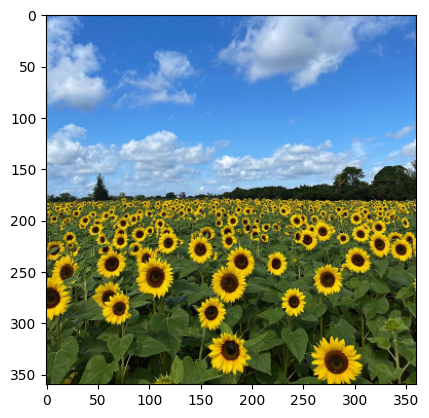

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

im = cv.imread('./the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
#plot image
plt.imshow(im)    

Parameters of the largest circle:
Center: (257, 212)
Radius: 15
Sigma value: 2.0


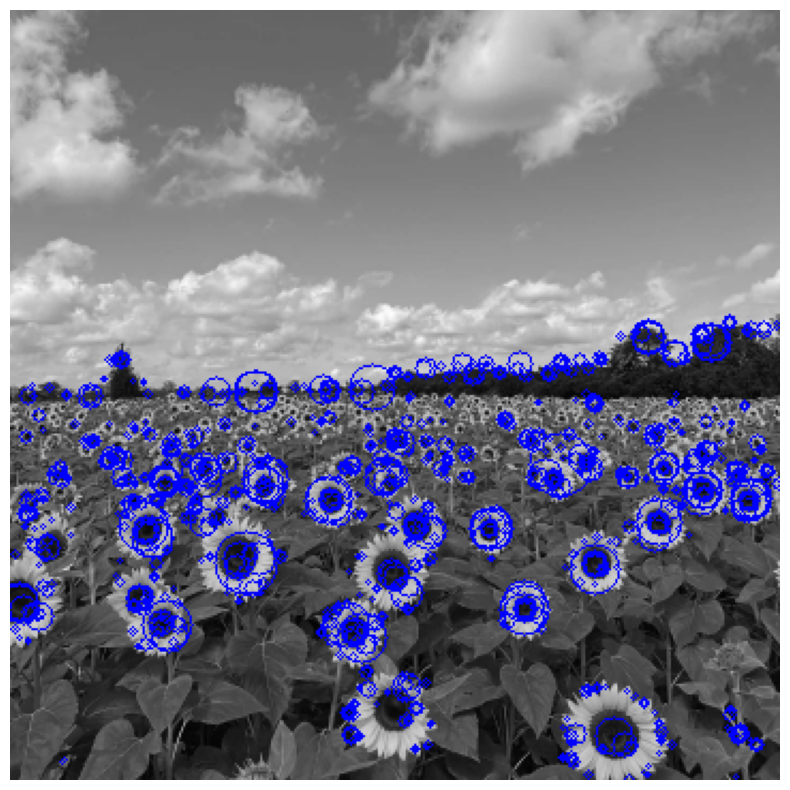

In [44]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Loading the image
image_path = './the_berry_farms_sunflower_field.jpeg'
image = cv.imread(image_path, cv.IMREAD_REDUCED_COLOR_4)

#Converting the image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)


# Setting parameters for scale-space extrema detection
min_sigma = 1.0  # Minimum sigma value
max_sigma = 2.0  # Maximum sigma value 
num_sigma = 5   # Number of sigma values to test
threshold = 0.35  # Threshold for blob detection

# Creating an empty list to store detected circles
detected_circles = []

# Loop through different sigma values to detect blobs at different scales
for current_sigma in np.linspace(min_sigma, max_sigma, num_sigma):
    # Applying Gaussian blur to the grayscale image with the current sigma
    blurred_image = cv.GaussianBlur(gray_image, (0, 0), current_sigma)
    laplacian = cv.Laplacian(blurred_image, cv.CV_64F)

    # Calculating the absolute Laplacian values
    abs_laplacian = np.abs(laplacian)

    # Creating a binary image where blobs are detected using the threshold
    blob_mask = abs_laplacian > threshold * abs_laplacian.max()

    # Finding contours in the blob mask
    contours, _ = cv.findContours(blob_mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Looping through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            detected_circles.append((center, radius, current_sigma))

# Sorting the detected circles by radius in descending order
detected_circles.sort(key=lambda circle: circle[1])

# Report the parameters of the largest circle

largest_circle = detected_circles[-1]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma value: {sigma}")


# Draw all detected circles with the specified line thickness
output_image = cv.cvtColor(gray_image, cv.COLOR_GRAY2BGR)
for circle in detected_circles:
    center, radius, _ = circle
    cv.circle(output_image, center, radius,(255,0,0),1)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

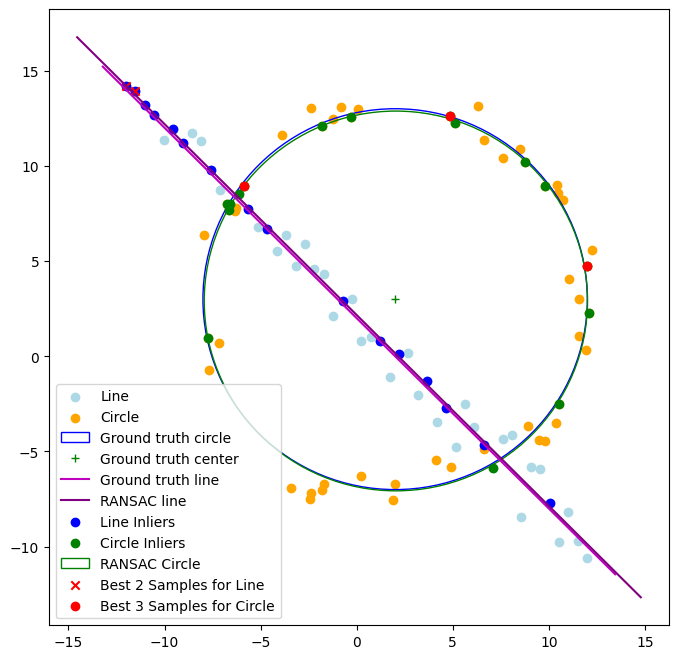

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'orange', label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')



# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    # Calculate the radius
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2  # Adjust the threshold as needed
circle_min_inliers = 15

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(X)) if i not in Line_inlier_indices]
remnant_points = X[remnant_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)


# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')


ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='blue', label='Line Inliers')


# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]


# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inlier_indices, 0], remnant_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]


# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')


plt.legend()
plt.show()

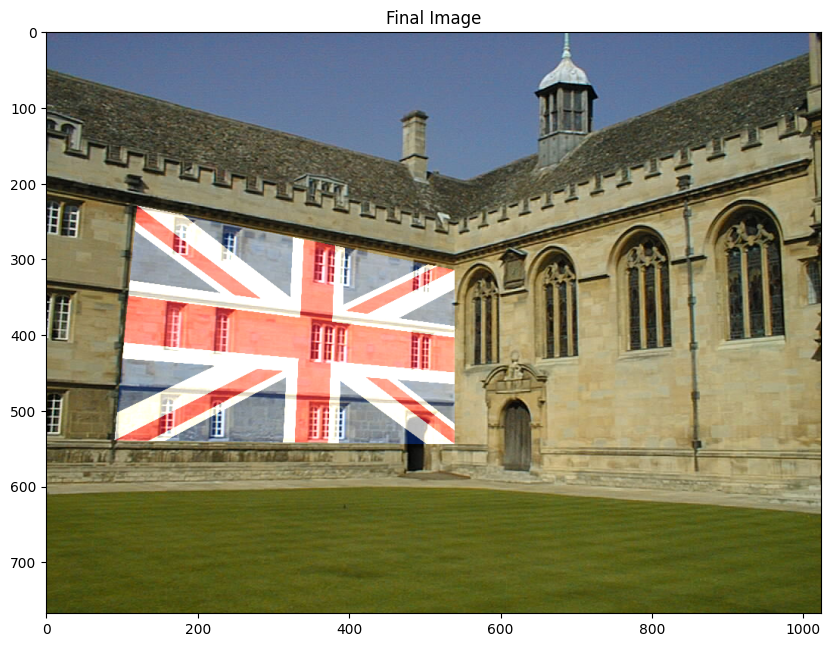

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_image = cv2.imread('Architectural Building.jpg')
flag_image = cv2.imread('Flag_of_the_United_Kingdom.png')


# Define the four points on the architectural image that form a planar surface
# Replace these with the actual coordinates
points_on_architecture = np.array([[120, 230], [540, 315], [540, 545], [90, 540]], dtype=np.float32)

# Define the corresponding points on the flag image (in the same order)
points_on_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_flag, points_on_architecture)

# Warp the flag image onto the architectural image using the homography
flag_warped = cv2.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Blend the warped flag image with the architectural image
result_image = cv2.addWeighted(architectural_image, 1, flag_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Final Image')
plt.show()

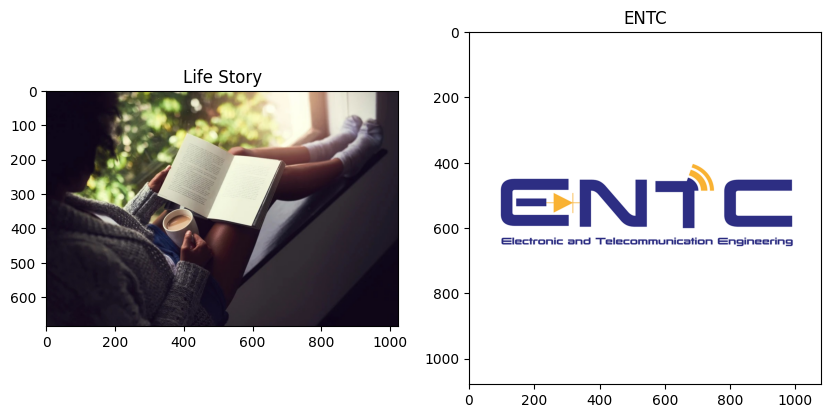

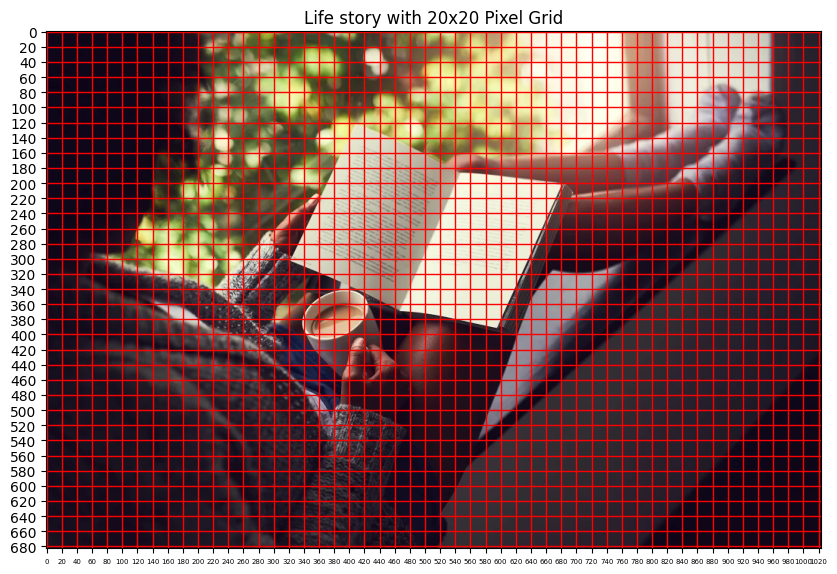

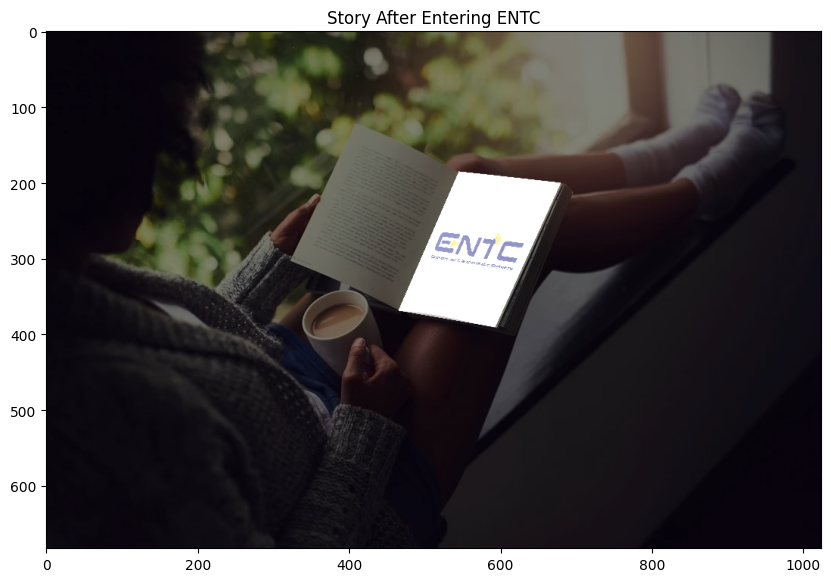

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the Girl with the book and the ENTC logo
book_image = cv2.imread('Girl_reading_a_book.jpeg')
ENTC_image = cv2.imread('ENTC logo.png')

# Display two images side-by-side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(book_image, cv2.COLOR_BGR2RGB))
plt.title('Life Story')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ENTC_image, cv2.COLOR_BGR2RGB))
plt.title('ENTC')
plt.show()

# Display the monitor image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(book_image, cv2.COLOR_BGR2RGB))
plt.xticks(np.arange(0, book_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, book_image.shape[0], 20))
plt.grid(True, color='red', linewidth=1)
plt.title('Life story with 20x20 Pixel Grid')
plt.show()

# Define the four points on the monitor image that form a planar surface
# Replace these with the actual coordinates
points_on_monitor = np.array([[545, 185], [680, 200], [593, 391], [465, 369]], dtype=np.float32)

# Define the corresponding points on the wallpaper image (in the same order)
points_on_wallpaper = np.array([[0, 0], [ENTC_image.shape[1], 0], [ENTC_image.shape[1], ENTC_image.shape[0]], [0, ENTC_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_wallpaper, points_on_monitor)

# Warp the wallpaper image onto the monitor image using the homography
wallpaper_warped = cv2.warpPerspective(ENTC_image, homography_matrix, (book_image.shape[1], book_image.shape[0]))

# Blend the warped wallpaper image with the monitor image
result_image = cv2.addWeighted(book_image, 0.5, wallpaper_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Story After Entering ENTC')
plt.show()

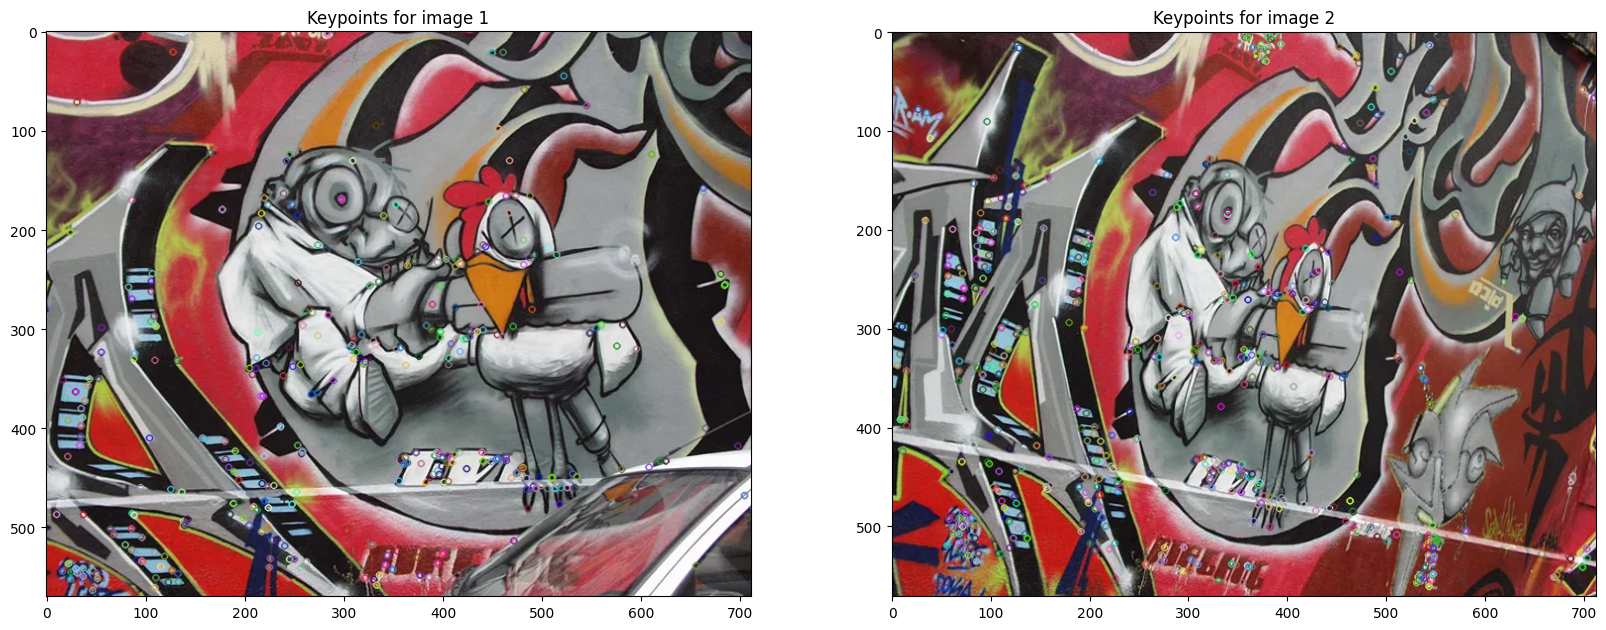

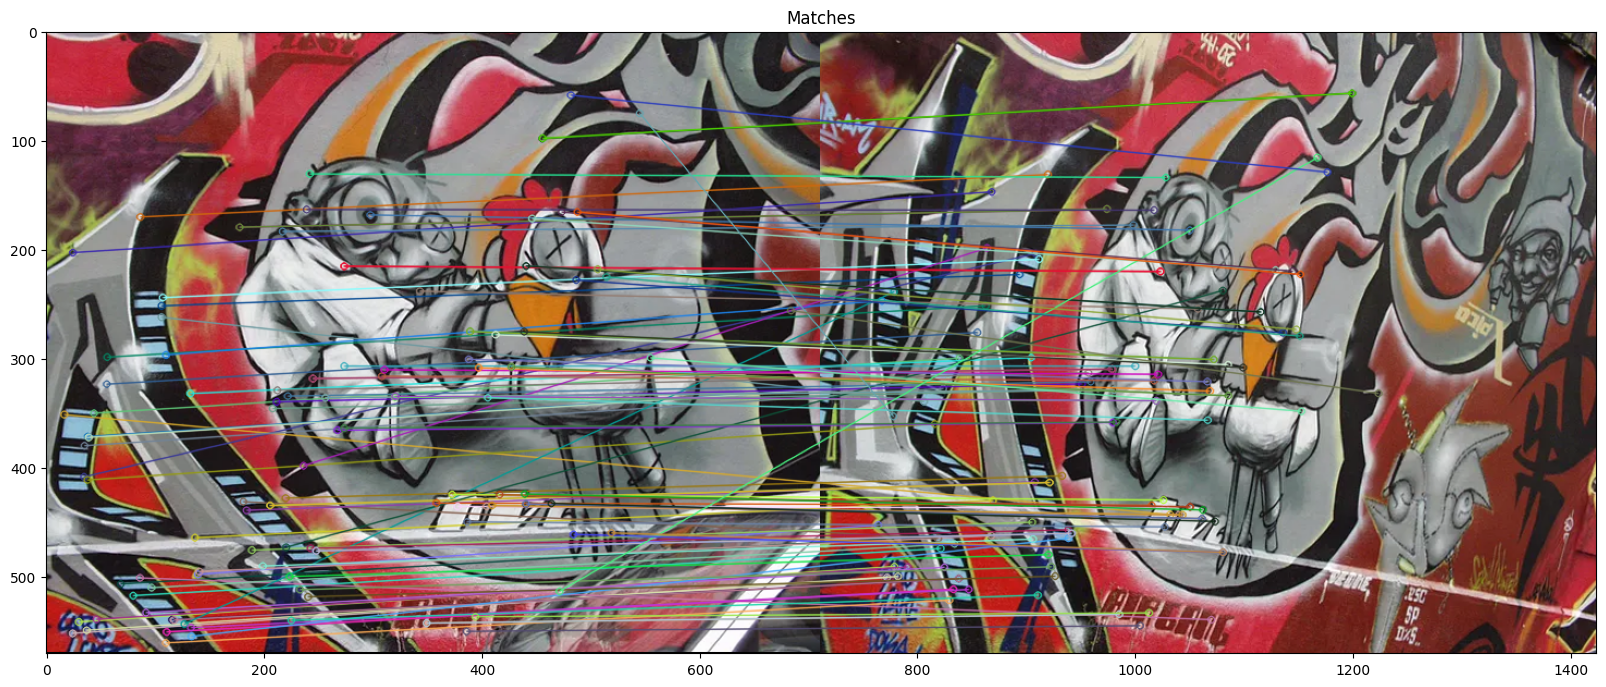

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im1 = cv.imread('Graffiti 1.png')
im2 = cv.imread('Graffiti 2.png')

assert im1 is not None
assert im2 is not None



#create a sift object
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.15, edgeThreshold=5, sigma=1)

#detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

#draw keypoints
im1_kp = cv.drawKeypoints(im1, kp1, None)
im2_kp = cv.drawKeypoints(im2, kp2, None)

#plot images
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(cv.cvtColor(im1_kp, cv.COLOR_BGR2RGB))
plt.title('Keypoints for image 1')
plt.subplot(122)
plt.imshow(cv.cvtColor(im2_kp, cv.COLOR_BGR2RGB))
plt.title('Keypoints for image 2')
plt.show()

#match keypoints
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

#apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

#draw matches
im_matches = cv.drawMatchesKnn(im1, kp1, im2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#plot image
plt.figure(figsize=(20,20))
plt.imshow(cv.cvtColor(im_matches, cv.COLOR_BGR2RGB))
plt.title('Matches')
plt.show()

In [18]:
#create a sift object
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.15, edgeThreshold=5, sigma=1)
#detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)
#match keypoints
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
#apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

[[ 7.36048235e-01 -2.81487978e-01  1.98520953e+02]
 [ 3.19849606e-01  9.97364080e-01 -6.13454296e+01]
 [ 3.62965420e-04 -3.42111366e-05  1.00000000e+00]]


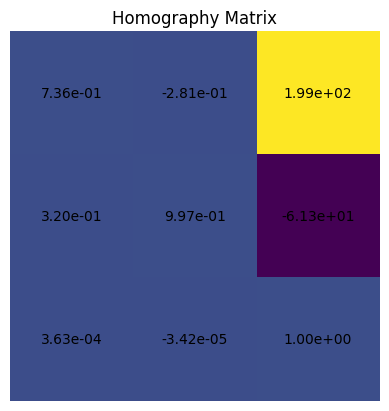

In [19]:
import cv2 as cv
import numpy as np
from scipy import linalg


# Detect keypoints and compute descriptors for both images using SIFT
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.08, edgeThreshold=8, sigma=1)

kp1, desc1 = sift.detectAndCompute(im1, None)
kp2, desc2 = sift.detectAndCompute(im2, None)

# Create a Brute-Force Matcher and perform keypoint matching
bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

# Apply the ratio test to filter good matches and extract corresponding keypoints
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

# Convert lists to NumPy arrays for further processing
good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)

# Draw the good matches
matched_img = cv.drawMatchesKnn(im1, kp1, im2, kp2, good[:50], None, flags=2)

# Define a function to compute the homography matrix
def homography(pts1, pts2):
    # Calculate mean and scaling factors for normalization
    mean1, mean2 = np.mean(pts1, axis=0), np.mean(pts2, axis=0)
    s1 = len(pts1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((pts1 - mean1) ** 2, axis=1)))
    s2 = len(pts1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((pts2 - mean2) ** 2, axis=1))) 
    # Compute the transformation matrices
    tx1, ty1, tx2, ty2 = -s1 * mean1[0], -s1 * mean1[1], -s2 * mean2[0], -s2 * mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []
    # Construct the matrix A for solving the linear system
    for i in range(len(pts1)):
        X11, X21 = T1 @ np.concatenate((pts1[i], [1])).reshape(3, 1), T2 @ np.concatenate((pts2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0] * X11[0][0], X21[0][0] * X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0] * X11[0][0], X21[1][0] * X11[1][0], X21[1][0])) 
    A = np.array(A)
 # Solve the linear system using SVD
    U, S, V = np.linalg.svd(A, full_matrices=True)
    h = np.reshape(V[-1], (3, 3))
    # Normalize the homography matrix and return
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H
    return H

# Define a function to compute the Euclidean distance between two points after applying the homography
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])
    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate  
    return np.linalg.norm(p2.T - p2_estimate)

# Define a function for RANSAC-based homography estimation
def RANSAC_homography(points1, points2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((points1, points2))
    # Calculate the number of iterations based on the probability of outlier detection
    num_iterations = int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5) ** 4))
    for _ in range(num_iterations):
        np.random.shuffle(points)
        pts1, pts1_rem, pts2, pts2_rem = points[:4, :2],  points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = homography(pts1, pts2)
        inliers = [(pts1_rem[i], pts2_rem[i]) for i in range(len(pts1_rem)) if dist(pts1_rem[i], pts2_rem[i], H) < 100]  
        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)
    # Compute the final homography matrix using the selected inliers
    H = homography(selected_inliers[:, 0], selected_inliers[:, 1]) 
    return H
# Call the RANSAC-based homography estimation function
H = RANSAC_homography(pts1, pts2)
# Print the computed homography matrix
print(H)




import matplotlib.pyplot as plt
import numpy as np

# Sample 2D matrix
matrix = H

# Create a heatmap plot with cell values
plt.imshow(matrix)
#plt.colorbar()  # Add a colorbar to the plot

# Annotate cells with values
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, f'{matrix[i, j]:.2e}', ha='center', va='center', color='black')


plt.title('Homography Matrix')
plt.axis('off')


plt.show()

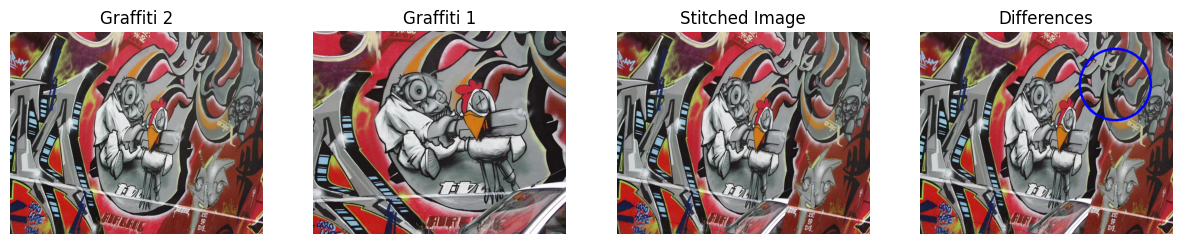

In [22]:
# Convert the list of tuples to a NumPy array
H = np.array(H)

# Warp im1 using the perspective transformation matrix H to match the shape of im2
img_p = cv.warpPerspective(im1, H, (im2.shape[1], im2.shape[0]))

# Threshold the warped image to create a binary mask
# Pixels with values above 10 become 1, and pixels below 10 become 0 (inverted)
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)

# Multiply the binary mask with im2 to extract the common region
img2_thresholded = np.multiply(threshold, im2)

# Blend the thresholded image with the warped image
img_blended = cv.addWeighted(img2_thresholded, 1, img_p, 1, 0)

# Create a figure with three subplots for visualization
fig, ax = plt.subplots(1, 4, figsize=(15, 12))

# Display im2
ax[0].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[0].set_title("Graffiti 2")
ax[0].axis("off")

# Display the stitched image
ax[2].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[2].set_title("Stitched Image")
ax[2].axis("off")

# Add a circle to highlight the difference between the images
img_blended = cv.circle(img_blended, (550, 150), 100, (255, 0, 0), 5)

# Display the image with the circle
ax[3].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[3].set_title("Differences")
ax[3].axis("off")

ax[1].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[1].set_title("Graffiti 1")
ax[1].axis("off")

# Show the figure with the subplots
plt.show()